# Реализация линейной операции в TensorFlow

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

## Генерируем данные для задачи регрессии

In [3]:
NUM_FEATURES = 1
NUM_SAMPLES = 995

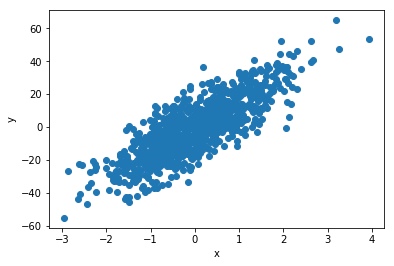

In [4]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples = NUM_SAMPLES,
                       n_features = NUM_FEATURES,
                       n_informative = NUM_FEATURES,
                       noise = 10,
                       random_state = 12345)

y = y.reshape(-1, 1)

order = np.argsort(X[:, 0])  # данные упорядочены по X

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[order, 0], y[order], 'o');

## Вспомогательная функция для создания операций

In [5]:
import string

def py_func_with_grad(func, inp, Tout, grad, name = None, stateful = False, graph = None):
    

    name_prefix = ''.join(np.random.choice(list(string.ascii_letters), size = 10))
    
    name = '%s_%s' % (name_prefix, name or '')
    grad_func_name = '%s_grad' % name

    tf.RegisterGradient(grad_func_name)(grad)

    g = graph or tf.get_default_graph()
    with g.gradient_override_map({'PyFunc': grad_func_name, 
                                  'PyFuncStateless': grad_func_name}):
        with tf.name_scope(name, 'PyFuncOp', inp):
            return tf.py_func(func, inp, Tout, stateful = stateful, name = name)

## Реализация линейной опреаций

In [6]:
def linear_op_forward(X, W):
    ''' Реализация линейной операции '''
    return np.dot(X, W.T)  # аргументы являются numpy-массивами

def linear_op_backward(op, grads):
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели
    dX = tf.multiply(grads, W)
    dW = tf.reduce_sum(tf.multiply(X, grads),
                       axis = 0,
                       keep_dims = True)
    return dX, dW

## Создание графа вычислений и обучение модели

In [7]:
BATCH_SIZE = NUM_SAMPLES // 10

weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES])
    plh_y = tf.placeholder(dtype = tf.float32, shape = [None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES],
                                          dtype = tf.float32,
                                          seed = 12345))
    
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W],            # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # определяем квадратичную функцию потерь
    # результат предсказания сравнивается с правильным ответом для вычисления ошибки
    cost = tf.reduce_mean(tf.square(plh_y - var_Pred))
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.GradientDescentOptimizer(
        learning_rate = 0.3).minimize(cost)

    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    indices = np.arange(len(X))  # массив индексов объектов
    
    # выполняем итерации по 10-ти эпохам
    for epoch in range(10):
        
        # вначале каждой эпохи перемешиваем индексы
        np.random.shuffle(indices)
        
        # внутри каждой эпохи данные разбиваются на батчи
        for batch in range(len(X) // BATCH_SIZE):
            
            # выбираем индексы очередного батча
            batch_indices = indices[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

            # выполняем шаг обучения: вычисляем ошибку и обновляем веса
            loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                               feed_dict = {plh_X: X[batch_indices],  # передаем входные данные для вычисления
                                            plh_y: y[batch_indices]})
        
            # сохраняем занчения ошибки для построения кривой обучения
            learning_curve.append(loss)
            
            # выводим текущее значение ошибки для каждого 10го шага
            steps = len(learning_curve) - 1
            if steps % 10 == 0:
                print('[%03d] loss=%.3f weights=%s' % (steps, loss, var_W.eval()))
    
    # сохраняем обученные веса
    weights = var_W.eval()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
[000] loss=318.528 weights=[[9.9628]]
[010] loss=98.848 weights=[[14.345516]]
[020] loss=86.585 weights=[[13.339043]]
[030] loss=86.063 weights=[[14.5847025]]
[040] loss=100.314 weights=[[14.6685295]]
[050] loss=84.212 weights=[[15.142481]]
[060] loss=117.103 weights=[[13.844067]]
[070] loss=76.406 weights=[[14.522823]]
[080] loss=119.047 weights=[[13.3612175]]
[090] loss=102.054 weights=[[15.687368]]


## Визуализируем кривую обучения

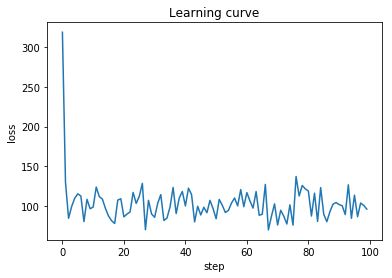

In [8]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve')
plt.plot(learning_curve);

## Визуализируем предсказания модели

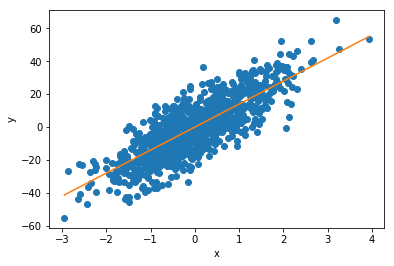

In [9]:
y_pred = np.dot(X, weights.T)  # предсказание модели

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[order, 0], y[order], 'o',
         X[order, 0], y_pred[order], '-');